## Table of content
1) Load libraries and prepare data  
1.1) Load libraries  
1.2) Prepare data  

2) Survival analysis  
2.1) Wrong way  
2.2) Survival curve - Kaplan Meier estimates  
2.3) Kaplan Meier estimates for above- and below-median groups (epss and lvdd)  
2.4) Hypothesis testing - Log-rank test  
2.5) Cox Proportional Hazards model  
2.6) Testing proportional hazards assumption  

3) Summary


## 1) Load libraries and prepare data

### 1.1) Load libraries

In [1]:
# Import packages
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

from scipy.stats import pearsonr

import statistics

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt

### 1.2) Prepare data

In [2]:
# Load the data. This data has been cleaned and fillna.
df = pd.read_csv("df.csv", index_col=0)

In [3]:
# Create variable "dead" as for argument "event_observed"
df.loc[df.alive == 1, 'dead'] = 0
df.loc[df.alive == 0, 'dead'] = 1

In [4]:
df.head()

,survival,alive,pericardialeffusion,age,fractionalshortening,epss,lvdd,wallmotion_index,dead
0,11.0,0,0,71.0,0.260,9.000,4.600,1.00,1.0
1,19.0,0,0,72.0,0.380,6.000,4.100,1.70,1.0
2,16.0,0,0,55.0,0.260,4.000,3.420,1.00,1.0
3,57.0,0,0,60.0,0.253,12.062,4.603,1.45,1.0
4,19.0,1,0,57.0,0.160,22.000,5.750,2.25,0.0


- The dataset is about the survival time in months after suffering heart attach. We have 130 obseravations; the data has been cleaned and filled missing values.
- Normally in a marchine learning problem, we have only one outcome variable for example survival time. But for survival analysis we have censoring. I.e. we have to stop our study at some time (i.e. we do not have the money to continue study forever).
    - So we have two outcome variables: "survival" = survival time in months.
    - "dead" whether the event (dead) was observed by the end of the study.
    - Show difference in observations 0 and 4 
    - "live" is opposite to "dead". We can ignore this variable.
- Other features are the conditions of the patients at the time of heart attact.
    - "pericardialeffusion" is binary variable whether there is fluid around heart.
    - Other variables are different measurements of the heart.

- Natural research question would be how these features affect the patients' survival time? 

## 2) Survival analysis

### 2.1) Wrong way

In [5]:
df["dead"].value_counts()

1.0    88
0.0    42
Name: dead, dtype: int64

- 42 observations are censored. I.e. 42 patients were still alive at the end of the study.
    - Rule of thumb "if more than 50% of observations are censored, survival analysis has limited effectiveness" => here we are OK with 42 censored out of 130.

#### Correlation between survival time and features for observations with "dead" = 1

In [10]:
# Correlation of survival time and covariate for observations that are not censored
df[df["dead"]==1].corr().round(2).iloc[0, 2:8]

pericardialeffusion    -0.05
age                    -0.00
fractionalshortening    0.08
epss                   -0.12
lvdd                   -0.11
wallmotion_index       -0.07
Name: survival, dtype: float64

In [14]:
pearsonr(df[df["dead"]==1].survival, df[df["dead"]==1].epss)

PearsonRResult(statistic=-0.11754605355674923, pvalue=0.27540506445717433)

In [12]:
pearsonr(df[df["dead"]==1].survival, df[df["dead"]==1].lvdd)

PearsonRResult(statistic=-0.10686382475838245, pvalue=0.3216957388728704)

- Correlation of "survival" and features are low. The two highest correlations are with epss and lvdd. Correlation values are -0.12 and -0.11.
    - The correlations are not significant. This might highlight the challenge of using this dataset - only small number of observations.

- RESEARCH QUESTION: Now let narrow the research question: if epss and lvdd affect the survival time of the patients?

- But we just follow a "Wrong way". The fact that a patient live until the end of the study include valuable information. We should not throw those observations away.

### 2.2) Survival curve - Kaplan Meier estimates

In [15]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df["survival"], event_observed=df["dead"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 130 total observations, 42 right-censored observations>

<AxesSubplot:xlabel='timeline'>

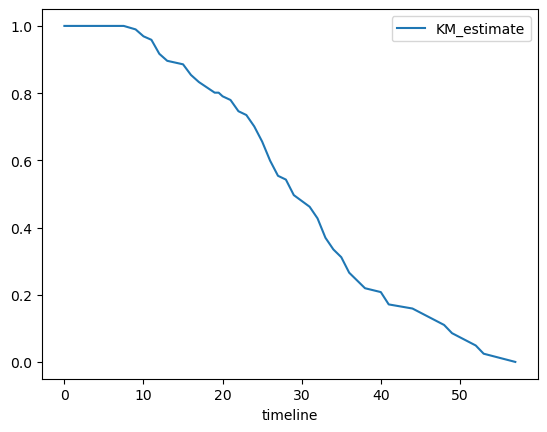

In [16]:
kmf.survival_function_.plot()

In [17]:
print(kmf.median_survival_time_, statistics.median(df[df["dead"]==1]['survival']))
# Should these two numbers are equal???

29.0 29.0


In [18]:
print(statistics.median(df['survival']))

23.5


In [19]:
kmf.predict(50)

0.07334904033084463

- Here we have survival curve. Show x=29 => y=50; this means the probability survive longer than 29 months is 50%.

### 2.3) Kaplan Meier estimates for above- and below-median groups (epss and lvdd)

In [20]:
T = df['survival']
E = df['dead']

In [21]:
# Write function to plot for groups
def kmf_by_gr(var):
    group = df[var] < statistics.median(df[var]) # group is series of boolean
    ax = plt.subplot(111)
    kmf.fit(T[group], event_observed = E[group], label = (var + ' below median'))
    print(kmf)
    kmf.survival_function_.plot(ax = ax)
    kmf.fit(T[~group], event_observed = E[~group], label = (var + ' above median'))
    print(kmf)
    kmf.survival_function_.plot(ax = ax)
    plt.title(("Kaplan Meier estimates by " + var + " group"))
    plt.xlabel("Month after heart attack")
    plt.ylabel("Survival")
    plt.show()

<lifelines.KaplanMeierFitter:"epss below median", fitted with 63 total observations, 11 right-censored observations>
<lifelines.KaplanMeierFitter:"epss above median", fitted with 67 total observations, 31 right-censored observations>


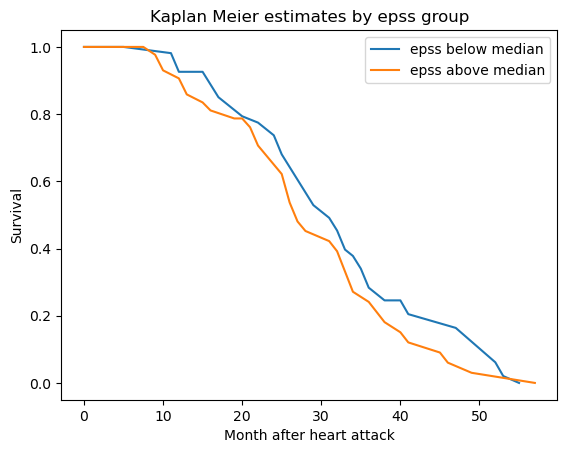

<lifelines.KaplanMeierFitter:"lvdd below median", fitted with 64 total observations, 11 right-censored observations>
<lifelines.KaplanMeierFitter:"lvdd above median", fitted with 66 total observations, 31 right-censored observations>


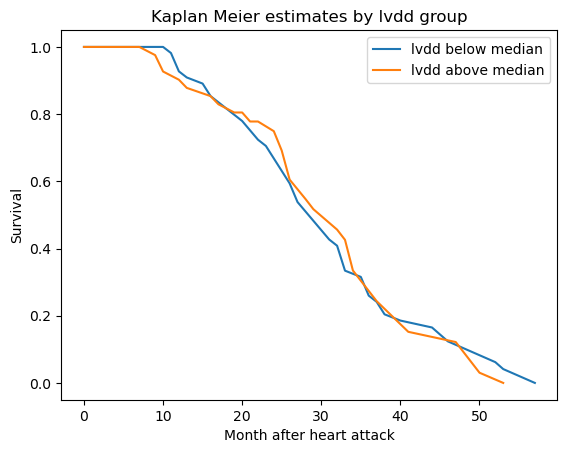

In [22]:
for var in ["epss", "lvdd"]:
    kmf_by_gr(var)

- Now we divide the sample into two subsample below- and above-median of epss (or lvdd).
- Remember when we carry the analysis the wrong way epss and lvdd have similar correlaton with survival time. Now we do the correct way and see it seems that epss affects survival time, and lvdd does not.
    - The survival curve for subsample with epss that below the median is above for those with high epss. That is for any given time, the prob of survival longer than this time is higher for low epss.

### 2.4) Hypothesis testing - Log-rank test

In [ ]:
# Some of code is take from this example https://www.kaggle.com/code/yukikitayama/survival-analysis

#### Testing for epss groups
#### H_0: Two subsamples (below- and above-median) by epss have the same survival curves.
#### H_1: They have different survival curves.

In [25]:
epss_group = df['epss'] < statistics.median(df['epss'])

lrt = logrank_test(
    durations_A = T[epss_group],
    durations_B = T[~epss_group],
    event_observed_A = E[epss_group],
    event_observed_B = E[~epss_group])
lrt

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.03 0.31      1.69

#### Testing for lvdd groups

In [26]:
lvdd_group = df['lvdd'] < statistics.median(df['lvdd'])

lrt = logrank_test(
    durations_A = T[lvdd_group],
    durations_B = T[~lvdd_group],
    event_observed_A = E[lvdd_group],
    event_observed_B = E[~lvdd_group])
lrt

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.02 0.89      0.16

- Too bad both test results are not significant with p-values of 0.31 and 0.89.
    - Note the prob with few observations in dataset.
    - The p-values are much smaller for epss than for lvdd. This is consisent with the survival curves.

### 2.5) Cox Proportional Hazards model

In [27]:
coxph = CoxPHFitter()
coxph.fit(df=df,
         duration_col = "survival",
         event_col = "dead",
         formula = "pericardialeffusion + age + fractionalshortening + epss + lvdd + wallmotion_index")
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 total observations, 42 right-censored observations>
             duration col = 'survival'
                event col = 'dead'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 88
   partial log-likelihood = -311.89
         time fit was run = 2023-02-09 19:34:48 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                   -0.01       0.99       0.01            -0.04             0.02                 0.96                 1.02
epss                   0.01       1.01       0.02            -0.03             0.06                 0.97                 1.06
fractionalshortening  -0.62       0.54       1.20            -2.98             1.74                 0.05                 5.69
lvdd                   0.01       1.01       0.16            -0.31             0.33                 0.73                 1.39
pericardialeffusion    0.08       1.08       0.32            -0.55             0.71                 0.58                 2.03
wallmotion_index      -0.20       0.82       0.34            -0.88             0.48                 0.42                 1.61

                       cmp to     z    p   -log2(p)
covariate                                          
age                      0.00 -0.74 0.46       1.13
epss                     0.00  0.62 0.54       0.90
fractionalshortening     0.00 -0.52 0.61       0.72
lvdd                     0.00  0.05 0.96       0.06
pericardialeffusion      0.00  0.24 0.81       0.30
wallmotion_index         0.00 -0.58 0.56       0.83
---
Concordance = 0.54
Partial AIC = 635.78
log-likelihood ratio test = 1.83 on 6 df
-log2(p) of ll-ratio test = 0.10

- We have looked at the effect of epss and lvdd in isolation. But survival time is affected by other features such as age, whether there is fluid around heart. So we need to put all the features in a regression. In this case the Cox proportional hazards model.
    - After controling for the effects of other features, epss and lvdd have very small effects (coefficients) and not significant.

### 2.6) Testing proportional hazards assumptions
- Do we care about proportional hazards assumptions? This articles says "maybe, not much" https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
- However, we want to check here.
    - Looking at survival curves for epss and lvdd groups, the assumptions look good - the curves have similar shape (they are parallel) and don't really cross.
    - The cell below test formally.

In [28]:
coxph.check_assumptions(df, p_value_threshold=0.05)

Proportional hazard assumption looks okay.


[]

## 3) Summary

- Epss and lvdd do not seem to have effect on the survival time.
    - The small sample might cause the weak results.
- If we care about survival only to a certain lenght, for example 2 or 4 years, we can investigate if epss and lvdd affect the outcome?
    - We will need to recode the "survival" and "censored" variables.

## Recode to censor at 4 years and do Kaplan Meier curves, log-rank tests, and CoxPH.
- We could do 2 years. But if thre are too many cencored obsevations, the analysis is not reliable.

In [26]:
df48 = df
df48.head(2)

,survival,alive,pericardialeffusion,age,fractionalshortening,epss,lvdd,wallmotion_index,dead
0,11.0,0,0,71.0,0.26,9.0,4.6,1.0,1.0
1,19.0,0,0,72.0,0.38,6.0,4.1,1.7,1.0


In [27]:
df48["survival_48"] = df48["survival"]
df48.loc[df48["survival"] > 48, "survival_48"] = 48
df48["dead_48"] = df48["dead"]
df48.loc[df48["survival"] > 48, "dead_48"] = 0

In [28]:
df48.head()

,survival,alive,pericardialeffusion,age,fractionalshortening,epss,lvdd,wallmotion_index,dead,survival_48,dead_48
0,11.0,0,0,71.0,0.260,9.000,4.600,1.00,1.0,11.0,1.0
1,19.0,0,0,72.0,0.380,6.000,4.100,1.70,1.0,19.0,1.0
2,16.0,0,0,55.0,0.260,4.000,3.420,1.00,1.0,16.0,1.0
3,57.0,0,0,60.0,0.253,12.062,4.603,1.45,1.0,48.0,0.0
4,19.0,1,0,57.0,0.160,22.000,5.750,2.25,0.0,19.0,0.0


In [33]:
df48[df48["survival"] > 48]

,survival,alive,pericardialeffusion,age,fractionalshortening,epss,lvdd,wallmotion_index,dead,survival_48,dead_48
3,57.0,0,0,60.0,0.253,12.062,4.603,1.45,1.0,48.0,0.0
7,50.0,0,0,60.0,0.330,8.000,5.250,1.00,1.0,48.0,0.0
11,52.0,0,1,62.0,0.450,9.000,3.600,1.14,1.0,48.0,0.0
12,52.0,0,0,73.0,0.330,6.000,4.000,1.00,1.0,48.0,0.0
58,53.0,0,0,70.0,0.100,9.800,5.300,2.30,1.0,48.0,0.0
65,49.0,0,0,51.0,0.160,13.200,5.260,1.00,1.0,48.0,0.0
67,49.0,0,1,70.0,0.250,9.700,5.570,1.10,1.0,48.0,0.0
88,55.0,0,0,55.0,0.280,5.500,4.480,1.83,1.0,48.0,0.0
92,53.0,0,0,59.0,0.344,9.100,4.040,1.00,1.0,48.0,0.0


### Survival curve

In [34]:
kmf = KaplanMeierFitter()
kmf.fit(durations=df48["survival_48"], event_observed=df48["dead_48"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 130 total observations, 51 right-censored observations>

<AxesSubplot:xlabel='timeline'>

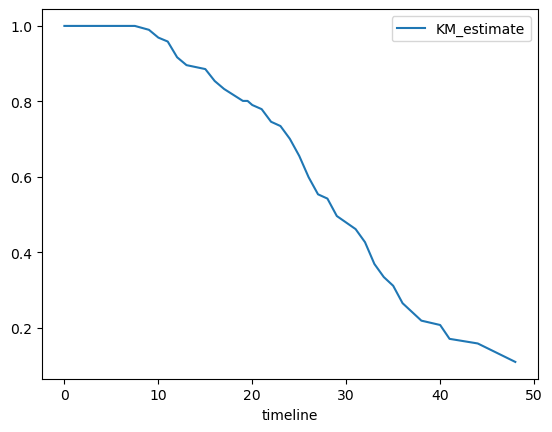

In [35]:
kmf.survival_function_.plot()

### Survival curve by groups

In [36]:
T48 = df['survival_48']
E48 = df['dead_48']

In [38]:
# Write function to plot for groups
def kmf_by_gr_48(var):
    group = df48[var] < statistics.median(df48[var]) # group is series of boolean
    ax = plt.subplot(111)
    kmf.fit(T48[group], event_observed = E48[group], label = (var + ' below median'))
    print(kmf)
    kmf.survival_function_.plot(ax = ax)
    kmf.fit(T48[~group], event_observed = E48[~group], label = (var + ' above median'))
    print(kmf)
    kmf.survival_function_.plot(ax = ax)
    plt.title(("Kaplan Meier estimates by " + var + " group"))
    plt.xlabel("Month after heart attack")
    plt.ylabel("Survival")
    plt.show()

<lifelines.KaplanMeierFitter:"age below median", fitted with 65 total observations, 20 right-censored observations>
<lifelines.KaplanMeierFitter:"age above median", fitted with 65 total observations, 31 right-censored observations>


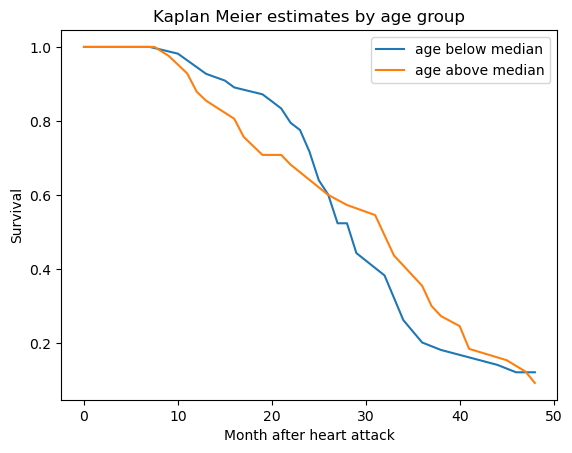

<lifelines.KaplanMeierFitter:"fractionalshortening below median", fitted with 62 total observations, 27 right-censored observations>
<lifelines.KaplanMeierFitter:"fractionalshortening above median", fitted with 68 total observations, 24 right-censored observations>


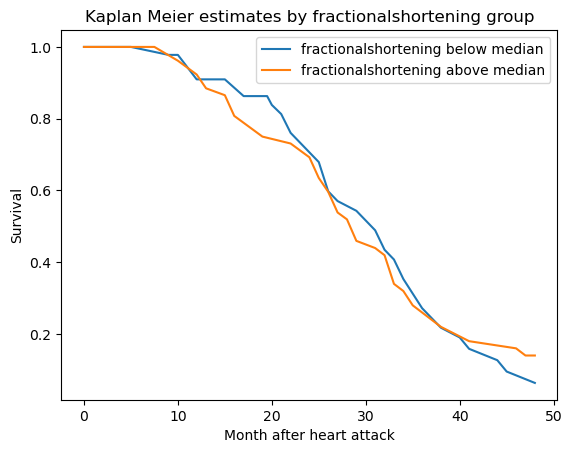

<lifelines.KaplanMeierFitter:"epss below median", fitted with 63 total observations, 18 right-censored observations>
<lifelines.KaplanMeierFitter:"epss above median", fitted with 67 total observations, 33 right-censored observations>


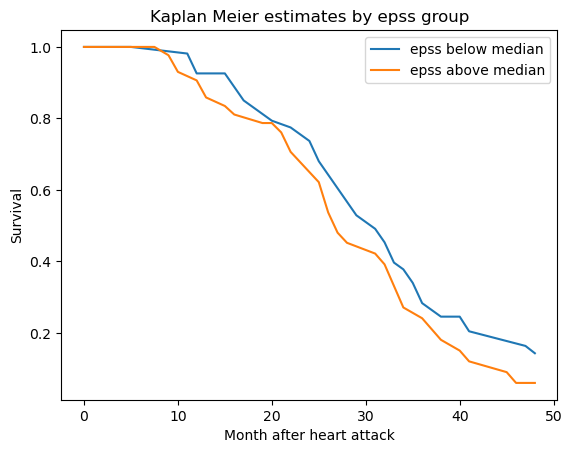

<lifelines.KaplanMeierFitter:"lvdd below median", fitted with 64 total observations, 16 right-censored observations>
<lifelines.KaplanMeierFitter:"lvdd above median", fitted with 66 total observations, 35 right-censored observations>


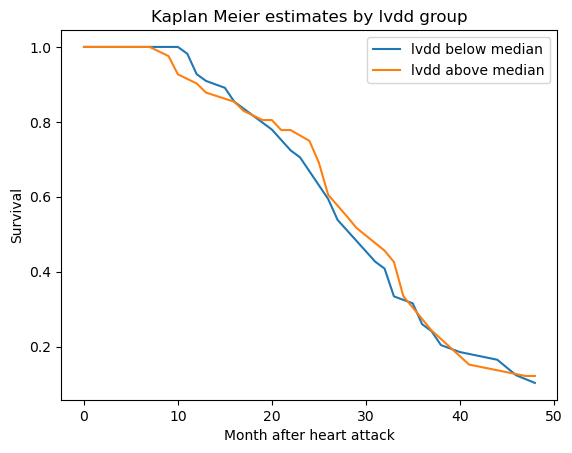

<lifelines.KaplanMeierFitter:"wallmotion_index below median", fitted with 65 total observations, 17 right-censored observations>
<lifelines.KaplanMeierFitter:"wallmotion_index above median", fitted with 65 total observations, 34 right-censored observations>


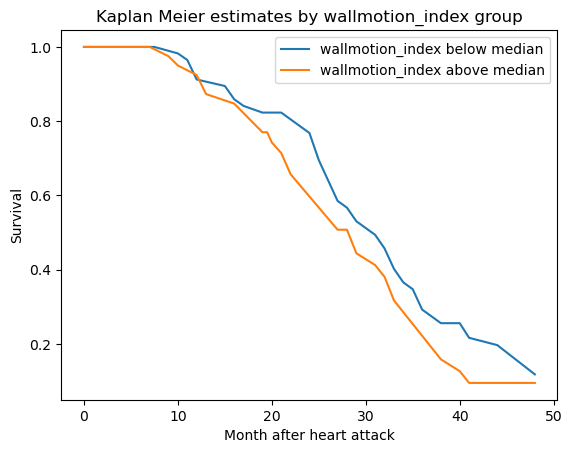

In [39]:
for var in ["age", "fractionalshortening", "epss", "lvdd", "wallmotion_index"]:
    kmf_by_gr_48(var)

### Logrank test

In [40]:
epss_group = df48['epss'] < statistics.median(df48['epss'])

lrt = logrank_test(
    durations_A = T48[epss_group],
    durations_B = T48[~epss_group],
    event_observed_A = E48[epss_group],
    event_observed_B = E48[~epss_group])
lrt

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.61 0.20      2.29

In [41]:
lvdd_group = df48['lvdd'] < statistics.median(df48['lvdd'])

lrt = logrank_test(
    durations_A = T48[lvdd_group],
    durations_B = T48[~lvdd_group],
    event_observed_A = E48[lvdd_group],
    event_observed_B = E48[~lvdd_group])
lrt

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.11 0.74      0.43

### CoxPH model

In [42]:
df48.head(2)

,survival,alive,pericardialeffusion,age,fractionalshortening,epss,lvdd,wallmotion_index,dead,survival_48,dead_48
0,11.0,0,0,71.0,0.26,9.0,4.6,1.0,1.0,11.0,1.0
1,19.0,0,0,72.0,0.38,6.0,4.1,1.7,1.0,19.0,1.0


In [43]:
coxph = CoxPHFitter()
coxph.fit(df=df48,
         duration_col = "survival_48",
         event_col = "dead_48",
         formula = "pericardialeffusion + age + fractionalshortening + epss + lvdd + wallmotion_index")

<lifelines.CoxPHFitter: fitted with 130 total observations, 51 right-censored observations>

In [44]:
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 130 total observations, 51 right-censored observations>
             duration col = 'survival_48'
                event col = 'dead_48'
      baseline estimation = breslow
   number of observations = 130
number of events observed = 79
   partial log-likelihood = -299.05
         time fit was run = 2023-02-08 19:57:56 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
age                   -0.01       0.99       0.01            -0.04             0.02                 0.96                 1.02
epss                   0.02       1.02       0.02            -0.03             0.06                 0.97                 1.07
fractionalshortening  -0.51       0.60       1.21            -2.89             1.87                 0.06                 6.48
lvdd                  -0.03       0.97       0.17            -0.37             0.30                 0.69                 1.35
pericardialeffusion   -0.09       0.91       0.35            -0.77             0.59                 0.46                 1.80
wallmotion_index       0.01       1.01       0.35            -0.69             0.70                 0.50                 2.01

                       cmp to     z    p   -log2(p)
covariate                                          
age                      0.00 -0.86 0.39       1.37
epss                     0.00  0.69 0.49       1.04
fractionalshortening     0.00 -0.42 0.67       0.57
lvdd                     0.00 -0.20 0.84       0.25
pericardialeffusion      0.00 -0.26 0.79       0.33
wallmotion_index         0.00  0.01 0.99       0.02
---
Concordance = 0.52
Partial AIC = 610.11
log-likelihood ratio test = 1.89 on 6 df
-log2(p) of ll-ratio test = 0.11